# Artificial Intelligence Insights into Regulations FOR The Treasury Board of Canada Secretariat

The notebook demonstrates the use of advanced analytics and machine learning methods to derive insights into the stock of federal regulations.  The objective is in this notebook is 3-fold:
* Usage of unsupervised machine learning algorithm to find the Nearest Neighbors for regulations, aka regulations which show similar wording and therefore have a high likelihood to be of similar content.
* Linkage of the stock of federal regulations to industry sectors
* Identification of regulations which potentially use archaic language.

The idea is to demonstrate the feasibility and benefits of some advanced analytics and AI ideas quickly in a 'garage' style mode. Throughout the objectives mentioned above, there is a focus on visualizing results in an appealing and intuitive manner. 

## THE LIBRARIES

In [15]:
# Standard libraries (are by default installed)
import os
import urllib
import zipfile
import xml.etree.ElementTree as et
import pickle
from bson.objectid import ObjectId
import datetime
import numpy as np
import re
import string
from IPython.display import Image

In [16]:
# Additional open source libraries (need to be installed)
from pymongo import MongoClient
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text 
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from py2neo import Graph, Node, Relationship
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

## THE DATA

The Justice Canada FTP server (ftp://205.193.86.89/) contains a file that is updated on an ongoing basis called data.zip (ftp://205.193.86.89/data.zip) that has the Acts and Regulations as of the date of archiving. The Regulations are marked up in XML format.
I have downloaded this data and stored it locally in a dir on my laptop.

In [17]:
# Dir for the xml files
p = '/Users/be08178/Documents/B&P/CanadianGovernment/'
f = 'data.zip'

In [21]:
dir_name = 'data/'
#os.makedirs(p+dir_name)

In [19]:
#urllib.urlcleanup()
#urllib.urlretrieve('ftp://205.193.86.89/', p+f)
# Issue to be solved, if downloaded this way => badzip

In [8]:
#zip_ref = zipfile.ZipFile(p+f, 'r')
#zip_ref.extractall(p+dir_name)
#zip_ref.close()

In [22]:
# Quick count of the number of XML files in the folder containing
# the stock of current regulations in English
p = p+dir_name+'Consolidation_2.0.0/English/Statutes/'
counter_docs_dir = 0
for f in os.listdir(p):
    if 'xml' in f:
        counter_docs_dir += 1
print counter_docs_dir

851


For easy retrieval we will store the data in a mongodb: https://www.mongodb.com

MongoDB is a free and open-source cross-platform document-oriented database program. Classified as a NoSQL database program, MongoDB uses JSON-like documents with schemata. 

### STORING THE DATA IN MONGODB

In [27]:
def connect_mongo(database):
    """
    Creates a connection to a mongo client and database
    Parameters
    ----------
    database: str
        Name of the database
    """
    from pymongo import MongoClient
    client = MongoClient()  # Making a connection with MongoClient
    db = eval('client.%s' % database)  # Making a connection with a database
    return db

In [28]:
def store_doc_in_mongo(doc, db, collection):
    """
    Stores the xml doc as a document in a mongodb collection
    Parameters
    ----------
    doc: dict
         The document to be stored, for example:
         doc = {'Name': name of the xml file,
                'XML: the entire xml
                'LongTitle': ,
                'BodyText': body_text}
    db: object returned by function connect_mongo(database)
        The mongodb database in which to store the document
    collection: string
        The name of a mongodb collection within the db in which to store the
        document
    """
    collection = eval('db.%s' % collection)
    try:
        collection.insert_one(doc)
    except Exception as e:
        error = str(e)
        print error

In [29]:
db = connect_mongo('CanRegGraph')

In [30]:
# In case you want to drop the collection beforehand to start afresh
db.RegulationsCurrentEnglish.drop()

In [32]:
for f in os.listdir(p):
    if 'xml' in f:
        fo = open(p+f,'r') 
        xml = fo.read()

        tree = et.parse(p+f)
        root = tree.getroot()
        for child in root:
            if child.tag == 'Identification':
                for elem in child.iter():
                    if elem.tag == 'LongTitle':
                        long_title = elem.text
                    if elem.tag == 'ShortTitle':
                        short_title = elem.text
                    if elem.tag == 'RunningHead':
                        running_head = elem.text
                    if elem.tag == 'BillHistory':
                        bill_history = [e.text for e in elem.iter() if e.text !=None]
                        bill_history_format = [e.tag for e in elem.iter() if e.text !=None]
            if child.tag == 'Body':
                body_text = ' '.join([elem.text for elem in child.iter() 
                                      if elem.text !=None])

        doc = {'Name': f,
               'XML': xml,
               'LongTitle': long_title,
               'ShortTitle': short_title,
               'RunningHead': running_head,
               'BillHistory': bill_history,
               'BillHistoryFormat': bill_history_format,
               'BodyText': body_text}
        collection = 'RegulationsCurrentEnglish'
        store_doc_in_mongo(doc, db, collection)

In [33]:
# Just checking if all the doc were stored
counter_docs_mongo = db.RegulationsCurrentEnglish.estimated_document_count()
flag = counter_docs_dir
if flag:
    print 'SUCCESS'
else:
    print 'WARNING'
print "There are %d in the dir and there are %d in mongo" %(counter_docs_dir, counter_docs_mongo)

SUCCESS
There are 851 in the dir and there are 851 in mongo


### RETRIEVING THE DATA FROM MONGODB

In [34]:
# Reading the data into a pandas dataframe
db = connect_mongo('CanRegGraph')
cursor = db.RegulationsCurrentEnglish.find()
df = pd.DataFrame(list(cursor))

In [35]:
# Let's have a look at the first 5 records
pd.set_option('display.max_colwidth', 50)
df.head()

,BillHistory,BillHistoryFormat,BodyText,LongTitle,Name,RunningHead,ShortTitle,XML,_id
0,"[1991, February, 1, 2018, 06, 21]","[YYYY, MM, DD, YYYY, MM, DD]",Short Title Short title 1 This Act may be cite...,An Act respecting a Day of Mourning for Person...,W-11.5.xml,Workers Mourning Day,Workers Mourning Day Act,"﻿<?xml version=""1.0"" encoding=""utf-8""?><!DOCTY...",5b671a827c33b10de5efedb4
1,"[2018, 06, 21, 2005, 11, 3]","[YYYY, MM, DD, YYYY, MM, DD]",Short Title Short title 1 This Act may be cite...,An Act to establish the Canada Border Services...,C-1.4.xml,Canada Border Services Agency,Canada Border Services Agency Act,"﻿<?xml version=""1.0"" encoding=""utf-8""?><!--Arb...",5b671a827c33b10de5efedb5
2,"[2018, 06, 21, 2005, 3, 23]","[YYYY, MM, DD, YYYY, MM, DD]",Short Title Short title 1 This Act may be cite...,An Act to establish the Department of Public S...,P-31.55.xml,Department of Public Safety and Emergency Prep...,Department of Public Safety and Emergency Prep...,"﻿<?xml version=""1.0"" encoding=""utf-8""?><!--Arb...",5b671a827c33b10de5efedb6
3,"[2018, 06, 21]","[YYYY, MM, DD]",Short Title Short title 1 This Act may be cite...,An Act respecting Construction of Works for th...,I-19.8.xml,International Rapids,International Rapids Power Development Act,"﻿<?xml version=""1.0"" encoding=""utf-8""?><!--Arb...",5b671a827c33b10de5efedb7
4,"[2002, April, 1, 2018, 06, 21]","[YYYY, MM, DD, YYYY, MM, DD]",Short Title Short title 1 This Act may be cite...,An Act to establish the Canadian Air Transport...,C-11.2.xml,Canadian Air Transport Security Authority,Canadian Air Transport Security Authority Act,"﻿<?xml version=""1.0"" encoding=""utf-8""?><!--Arb...",5b671a827c33b10de5efedb8


There is a LongTitle and a ShortTitle.  since titles often provide a useful summary of the entire content, they will play an important role in our Nearest Neighbor algo.  The LongTitle is missing in a couple of cases. The ShortTitle is always populated.

In [36]:
print len(df[df['LongTitle'].isnull()])
print len(df[df['ShortTitle'].isnull()])

3
0


We are going to combine the two titles in one field named Title.  For the vast majority of articles this will lead to certain keywords being repeated in the Title.  This is delibarate since we want to put a bit more weight on the words in the title than those in the body of the regulation.

In [37]:
def concat_title(row):
    """
    Combines the long and short title into one field
    """
    if row['LongTitle'] == None:
        if row['ShortTitle'] != None:
            title = row['ShortTitle']
        else:
            title = 'NoTitle'
    else:
        if row['LongTitle'] != None:
            title = row['LongTitle'] + row['ShortTitle']
        else:
            title = row['LongTitle']
    return title

df['Title'] = df.apply(concat_title, axis=1)

In [38]:
# The resulting title field is never blank
len(df[df['Title'].isnull()])

0

In [39]:
# The BodyText field is never blank
len(df[df['BodyText'].isnull()])

0

## NEAREST NEIGHBOR

We will use the text of the BodyText and the Title of the regulation as the input for our bag of words algo.

In [40]:
input_bag_of_words = df['BodyText'] + df['Title']

### Term Frequency Inverse Document Frequency

As features we are going to use the term frequency inverse document frequency of the words in the regulations (tfIdf)
TfIdf is a numerical statistic that is intended to reflect how important a word is to a document
relative to the entire corpus
We ignore stopwords like 'and', 'the', etc...

In [41]:
# The list with traditional stop words (the, a, and, or, ...) 
# can be expanded with additional words specific to the corpus, 
# see some examples here
# This should be expanded on in the real application in order to 
# improve the results
stop_words = text.ENGLISH_STOP_WORDS.union(['act',
                                            'canada',
                                            'canadian',
                                            'amendment',
                                            'amendments',
                                            'minister',
                                            'repeal',
                                            'department',
                                            'shall',
                                            'sections',
                                            'section'])

In [42]:
tfidf_vectorizer = TfidfVectorizer(decode_error='ignore',
                                   stop_words=stop_words)
bag_of_words = tfidf_vectorizer.fit_transform(input_bag_of_words)

We are using sklean's NearestNeigbor algo which is an Unsupervised learner for implementing neighbor searches.
http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors

Sklearn's NearestNeigbor algo, by default, uses the Minkowski distance metric, which can be considered as a generalization of both the Euclidean distance and the Manhattan distance.

The Minkowski distance of order p between two points

$$X = (x_1, x_2, ..., x_n) and Y = (y_1, y_2, ..., y_n) \in \mathbb{R}^n$$

is defined as:
$$D(Y, Y) = (\displaystyle\sum_{i=1}^{n} |x_i - y_i|^p)^{1/p} $$

In [43]:
nn_model = NearestNeighbors()
nn_model.fit(bag_of_words)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

For each regulations we will request the 5 nn.
The model produces two output matrices, one with the distances and one with the indices.
Let's look at a particular example randomly chosen.

In [44]:
dist, ind = nn_model.kneighbors(n_neighbors=5)
a = 5 # Random example
nn_a = ind[a]
print 'The nearest neighbors or regulation with index %d are: ' %(a), nn_a

The nearest neighbors or regulation with index 5 are:  [772 350 614  45 836]


In [45]:
print 'ORIGINAL'
print df['LongTitle'][a]
print '\n'
print 'NEIGHBORS'
for n in nn_a:
    print '-', df['LongTitle'][n]

ORIGINAL
An Act providing for the ratification and the bringing into effect of the Framework Agreement on First Nation Land Management


NEIGHBORS
- An Act respecting self-government for first nations in Yukon
- An Act to provide for jurisdiction over education on First Nation lands in British Columbia
- An Act respecting an agreement with the Norway House Cree Nation for the settlement of matters arising from the flooding of land, and respecting the establishment of certain reserves in the province of Manitoba
- An Act to provide first nations with the option of managing and regulating oil and gas exploration and exploitation and of receiving moneys otherwise held for them by Canada
- An Act to establish a board having jurisdiction concerning disputes respecting surface rights in respect of land in the Yukon Territory and to amend other Acts in relation thereto


### Visualizing the most influencal words in wordclouds

We should avoid that machine learning models are just back boxes, meaning that we do not have any insight into why the results are the way they are.  In this case we can look under the hood by looking at the words which were most influencial in determining that the above regulations are related to each other and look at which words these regulations have in common.  We will visualize this through the use of word clouds.

In [46]:
# Save the names of the features (words)
features = tfidf_vectorizer.get_feature_names()

In [47]:
# Save the 30 most influencial words per regulation
most_significant_words_all = bag_of_words.todense().argsort(axis=1)[:,-30:]

In [48]:
def generate_wordcloud(text, title):
    """
    Creates a wordcloud with the words in a text
    """
    wordcloud = WordCloud(background_color="white", colormap='summer').generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

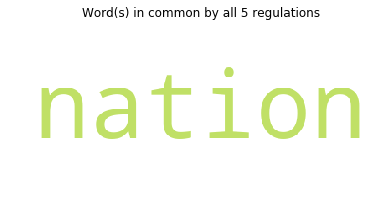

In [49]:
# Find those words out of these 30 which the 5 nn have in common
most_significant_words_a = most_significant_words_all[a,:] 
top_common_words = set(most_significant_words_a.tolist()[0])
common = []
for n in range(len(nn_a)):
    b = nn_a[n]
    most_significant_words_b = most_significant_words_all[b,:] 
    top_common_words_b = set(most_significant_words_b.tolist()[0])
    top_common_words.intersection_update(top_common_words_b)
for w in top_common_words:
        common.append(features[w])
generate_wordcloud(' '.join(common), 'Word(s) in common by all 5 regulations')

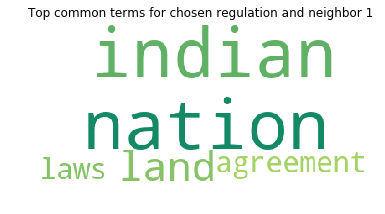

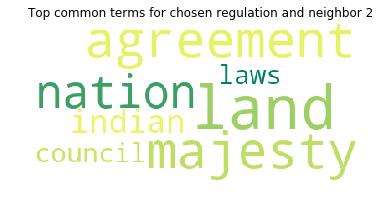

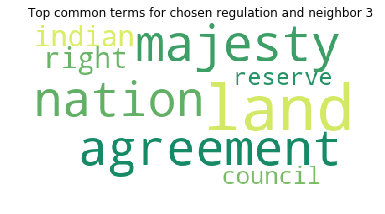

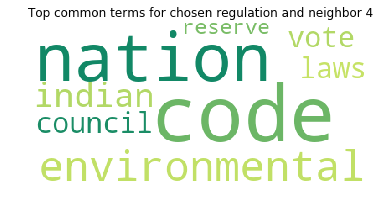

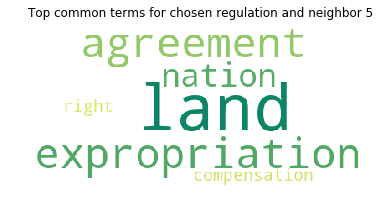

In [50]:
# Print the common words of the main regulation compared to each nn individually
for n in range(len(nn_a)):
    common = []
    nn_n = most_significant_words_all[[a, nn_a[n]],:]
    top_common_words = set(nn_n[0].tolist()[0])
    for r in nn_n[1:]:
        new_set = set(r.tolist()[0])
        top_common_words.intersection_update(new_set)
    for w in top_common_words:
        common.append(features[w])
    generate_wordcloud(' '.join(common), 'Top common terms for chosen regulation and neighbor %d' % (n+1))

Another way to visualize the result is that the regulations are nodes in a graph and 'is neighbor of' form edges between the nodes.  The most frequent words in the regulation are properties of the nodes.  We will use neo4j to generate the graph: https://neo4j.com/

### Visualizing the nearest neighbors in a graph

In mathematics, graph theory is the study of graphs, which are mathematical structures used to model pairwise relations between objects. A graph in this context is made up of nodes which are connected by edges.

We will use Neo4j, which is a graph database management system developed by Neo4j, Inc.  Neo4j is available in a GPL3-licensed open-source "community edition", with online backup and high availability extensions licensed under the terms of the Affero General Public License.

To interface from python with neo4j, we will use Py2neo which is a client library and toolkit for working with Neo4j from within Python applications and from the command line. 

In [51]:
# Initiate a neo4j graph object
graph = Graph("bolt://127.0.0.1:7687", user="neo4j", password="test123")

In [52]:
# In case you want to drop all the nodes and edges beforehand to start afresh
graph.delete_all()

In [53]:
# Let's go back to the regulation we examined up close above 
# and its nearest neighbors
main_reg_name =  df['Name'][a]
nn_reg_name = df.iloc[nn_a]['Name']
print main_reg_name, '\n', nn_reg_name

F-11.8.xml 
772      Y-2.6.xml
350    F-11.75.xml
614     M-0.53.xml
45      F-11.9.xml
836      Y-4.3.xml
Name: Name, dtype: object


In [54]:
# Let's create a node for the main regulation
Node_F11p8xml = Node("Regulation", name='F-11.8.xml')
# Let's create a node for the first neighbor
Node_Y26xml = Node("Regulation", name='Y-2.6.xml')
# Let's create an edge between the two
Edge_Node_Y26xmlNode_F11p8xml = Relationship(Node_Y26xml, "IS NN OF", Node_F11p8xml)

In [55]:
graph.create(Node_F11p8xml | Node_Y26xml | Edge_Node_Y26xmlNode_F11p8xml)

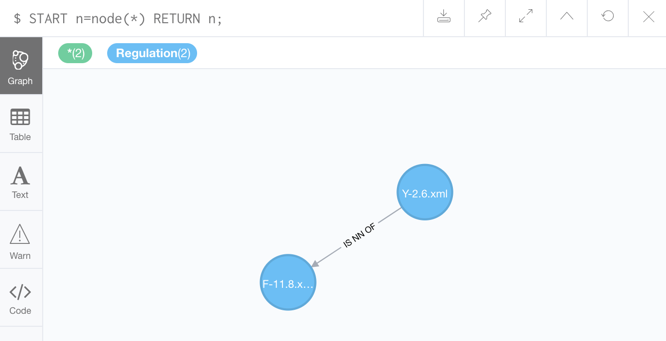

In [56]:
Image(filename='Images/FirstGraph.png') 

In [57]:
# In case you want to drop all the nodes and edges beforehand to start afresh
graph.delete_all()

In [58]:
# Now we can create a loop to create all the nodes and
# relationships in the example above (or for the full dataset)
name_main = main_reg_name.encode('ascii','ignore').translate(None, string.punctuation)
name_main = 'Node_' + name_main
name_main = Node("Regulation", name=main_reg_name)
graph.create(name_main)
for r in nn_reg_name:
    name_nn = r.encode('ascii','ignore').translate(None, string.punctuation)
    name_nn = 'Node_%s' % name_nn
    name_nn = Node("Regulation", name=r)
    graph.create(name_nn)
    name_edge = ('Node_%s'+r.encode('ascii','ignore').translate(None, string.punctuation) +
                 'Node_'+main_reg_name.encode('ascii','ignore').translate(None, string.punctuation))
    name_edge = 'Edge_%s' % name_edge 
    name_edge = Relationship(name_nn, "IS NN OF", name_main)
    graph.create(name_edge)

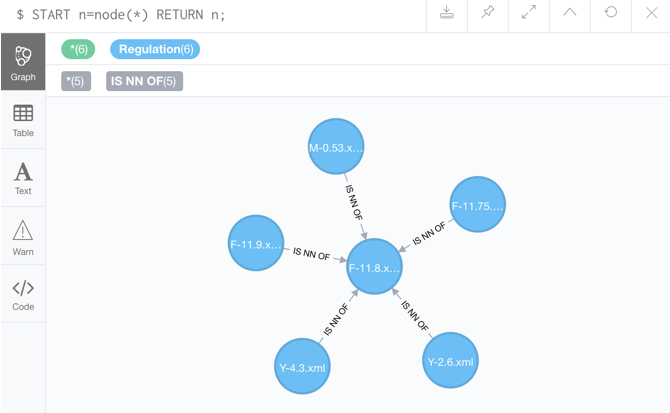

In [59]:
Image(filename='Images/SecondGraph.png') 

## INDUSTRY CLASSIFICATION

As the basis of our industry classification we will take the table found on the following site as an example https://www.statcan.gc.ca/eng/subjects/standard/naics/2017/index

In [60]:
f = 'NAICS-SCIAN-2017-Structure-V1-eng.csv'
industry = pd.read_csv(p+f)
industry = industry[industry['Level'] == 1].reset_index(drop=True) # Focus on highest level only
industry['Text'] = industry['Class title'] + industry['Class definition']
pd.set_option('display.max_colwidth', 50)
industry.head()

,Level,Hierarchical structure,Code,Class title,Superscript,Class definition,Text
0,1,Sector,11,"Agriculture, forestry, fishing and hunting",NaN,This sector comprises establishments primarily...,"Agriculture, forestry, fishing and huntingThis..."
1,1,Sector,21,"Mining, quarrying, and oil and gas extraction",NaN,This sector comprises establishments primarily...,"Mining, quarrying, and oil and gas extractionT..."
2,1,Sector,22,Utilities,NaN,This sector comprises establishments primarily...,UtilitiesThis sector comprises establishments ...
3,1,Sector,23,Construction,NaN,This sector comprises establishments primarily...,ConstructionThis sector comprises establishmen...
4,1,Sector,31-33,Manufacturing,NaN,This sector comprises establishments primarily...,ManufacturingThis sector comprises establishme...


In [61]:
print 'There are %d level one industries.' % len(industry)

There are 20 level one industries.


To step things up a little, let's convert the words in the text to the stems of these words to increase the likelyhood of words matching if in essence they represent the same thing.  Here is a dummy example to explain what we mean:

In [62]:
stemmer = SnowballStemmer("english")
print stemmer.stem('cats')
print stemmer.stem('cat')
print stemmer.stem('hunts')
print stemmer.stem('hunting')

cat
cat
hunt
hunt


In [63]:
# We can look into different kind of stemmers since does not get eveything right. 
print stemmer.stem('mice')
print stemmer.stem('mouse')
# For more info see
# https://pdfs.semanticscholar.org/1c0c/0fa35d4ff8a2f925eb955e48d655494bd167.pdf

mice
mous


In [64]:
# Let's create a little function to convert the words in a text
# into their corresponding stems
def get_text_stems(text):
    '''
    Converts the text into stems
    '''
    stop_words = stopwords.words('english')
    stemmer = SnowballStemmer("english")
    word_list = str(text.encode('ascii','ignore')).lower().translate(None, string.punctuation).split()
    stem_list = [stemmer.stem(w) for w in word_list if w not in stop_words]
    stem_text = ' '.join(stem_list)
    return stem_text

In [65]:
# We apply this function to the text data in the industry dataframe
industry['Text stems'] = industry['Text'].apply(get_text_stems)

In [66]:
# We apply this function to the text data in the main dataframe with regulations
# This takes a couple of minutes
df['BodyTextStems'] = df['BodyText'].apply(get_text_stems)
df['TitleStems'] = df['Title'].apply(get_text_stems)
df['BodyTitleStems'] = df['BodyTextStems'] + df['TitleStems'] + df['TitleStems'] + df['TitleStems'] + df['TitleStems'] + df['TitleStems'] + df['TitleStems']# Yes, we are adding the title many times as a quick and dirty way to add much more weight to the words in the title

To find similarity between the stems resprenting the industries and the text in the regulations, we will use a matrix multiplication technique this time.  To demonstrate what we mean, let's look at this dummy example:

In [67]:
dummy_vectorizer = TfidfVectorizer(stop_words=stop_words)

text = ["This sector comprises agriculture, fishing, hunting ",
        "This sector comprises oil and gas",
        "Act on oil drilling and reservoirs",
        "Regulation regarding hunting season and reservoirs."]

dummy_bag_of_words = dummy_vectorizer.fit_transform(text)

dummy_similarity_matrix = (dummy_bag_of_words * dummy_bag_of_words.T).A
dummy_similarity_matrix

array([[ 1.        ,  0.37361828,  0.        ,  0.15349619],
       [ 0.37361828,  1.        ,  0.24520415,  0.        ],
       [ 0.        ,  0.24520415,  1.        ,  0.20147785],
       [ 0.15349619,  0.        ,  0.20147785,  1.        ]])

In [68]:
# Lets display this matrix in a dataframe so it's a bit clearer what this represents
pd.DataFrame(dummy_similarity_matrix, columns=text, index=text)

,"This sector comprises agriculture, fishing, hunting",This sector comprises oil and gas,Act on oil drilling and reservoirs,Regulation regarding hunting season and reservoirs.
"This sector comprises agriculture, fishing, hunting",1.000000,0.373618,0.000000,0.153496
This sector comprises oil and gas,0.373618,1.000000,0.245204,0.000000
Act on oil drilling and reservoirs,0.000000,0.245204,1.000000,0.201478
Regulation regarding hunting season and reservoirs.,0.153496,0.000000,0.201478,1.000000


The values in this matrix show the similarity between the different pieces of text, which 1 being a perfect score. If we zoom in to the bottom left 4 values, we are looking at the values which are of interest to us.  We could equaly zoom in to the top right 4 values since they reprent the same info.

In [69]:
pd.DataFrame(dummy_similarity_matrix[2:,0:2], columns=text[:2], index=text[2:])

,"This sector comprises agriculture, fishing, hunting",This sector comprises oil and gas
Act on oil drilling and reservoirs,0.000000,0.245204
Regulation regarding hunting season and reservoirs.,0.153496,0.000000


Let's apply the same logic to our real data.  We will look into the same sample set we focussed on above for the nearest neighbors, aka the word clouds example.

In [70]:
# Let's add the main regulation and it's 5 nearest neighbors in to one list
nn = list(nn_a)
nn.insert(0, a)
nn

[5, 772, 350, 614, 45, 836]

In [71]:
# The model
input_bag_of_stems = industry['Text stems'].append(df['BodyTextStems'])
stem_vectorizer = TfidfVectorizer(decode_error='ignore',
                                  stop_words=stop_words)
bag_of_industry_stems = stem_vectorizer.fit_transform(input_bag_of_stems)
similarity_matrix = (bag_of_industry_stems * bag_of_industry_stems.T).A
similarity_matrix = similarity_matrix[20:,:20]
similarity_matrix_orig = similarity_matrix.copy()
highest_industry_similarity = [ ]
for row in similarity_matrix:
    highest_industry_similarity.append(row.argmax())
    row
highest_industry_similarity3 = [ ]
# Zoom in to the 3 highest similarity scores
for row in similarity_matrix:
    high1 = row.max()
    high1_ind = row.argmax()
    row[high1_ind] = 0
    high2 = row.max()
    high2_ind = row.argmax()
    row[high2_ind] = 0    
    high3 = row.max()
    high3_ind = row.argmax()
    highest_industry_similarity3.append([(high1, high1_ind),
                                         (high2, high2_ind),
                                         (high3, high3_ind),])

In [72]:
# Let's have a look how our model did on the list of 6 regulations
for n in nn:
    m = sorted(highest_industry_similarity3[n], key=lambda x: x[0], reverse=True)
    print df['LongTitle'][n]
    for i in m:
        print '-' + industry['Class title'][i[1]], '(Score ', i[0],  ')'
    print '\n'

An Act providing for the ratification and the bringing into effect of the Framework Agreement on First Nation Land Management
-Construction (Score  0.0549727314465 )
-Transportation and warehousing (Score  0.0429045110123 )
-Public administration (Score  0.0396748631613 )


An Act respecting self-government for first nations in Yukon
-Public administration (Score  0.0740882212254 )
-Transportation and warehousing (Score  0.0436120304482 )
-Professional, scientific and technical services (Score  0.0257551904972 )


An Act to provide for jurisdiction over education on First Nation lands in British Columbia
-Educational services (Score  0.15629386305 )
-Arts, entertainment and recreation (Score  0.0978786953673 )
-Professional, scientific and technical services (Score  0.0675608464825 )


An Act respecting an agreement with the Norway House Cree Nation for the settlement of matters arising from the flooding of land, and respecting the establishment of certain reserves in the province of M

Let's look at another sample where we can find for example the term contruction in the title of the article.

In [73]:
nn = df[df['Title'].str.contains('construction')].index

In [74]:
for n in nn:
    m = sorted(highest_industry_similarity3[n], key=lambda x: x[0], reverse=True)
    print df['LongTitle'][n]
    for i in m:
        print '-' + industry['Class title'][i[1]], '(Score ', i[0],  ')'
    print '\n'

An Act for carrying into effect the Agreements for an International Monetary Fund, an International Bank for Reconstruction and Development, an International Development Association and an International Finance Corporation and the Convention establishing the Multilateral Investment Guarantee Agency
-Finance and insurance (Score  0.15795112499 )
-Public administration (Score  0.0521025729975 )
-Health care and social assistance (Score  0.0472078289561 )


An Act to encourage the construction of dry docks
-Construction (Score  0.110427058883 )
-Manufacturing (Score  0.0562264259159 )
-Management of companies and enterprises (Score  0.0432455941204 )


An Act to provide for the membership of Canada in the European Bank for Reconstruction and Development
-Finance and insurance (Score  0.0401317681446 )
-Professional, scientific and technical services (Score  0.0273004498748 )
-Educational services (Score  0.0254762415075 )


An Act respecting the construction, operation and maintenance of 

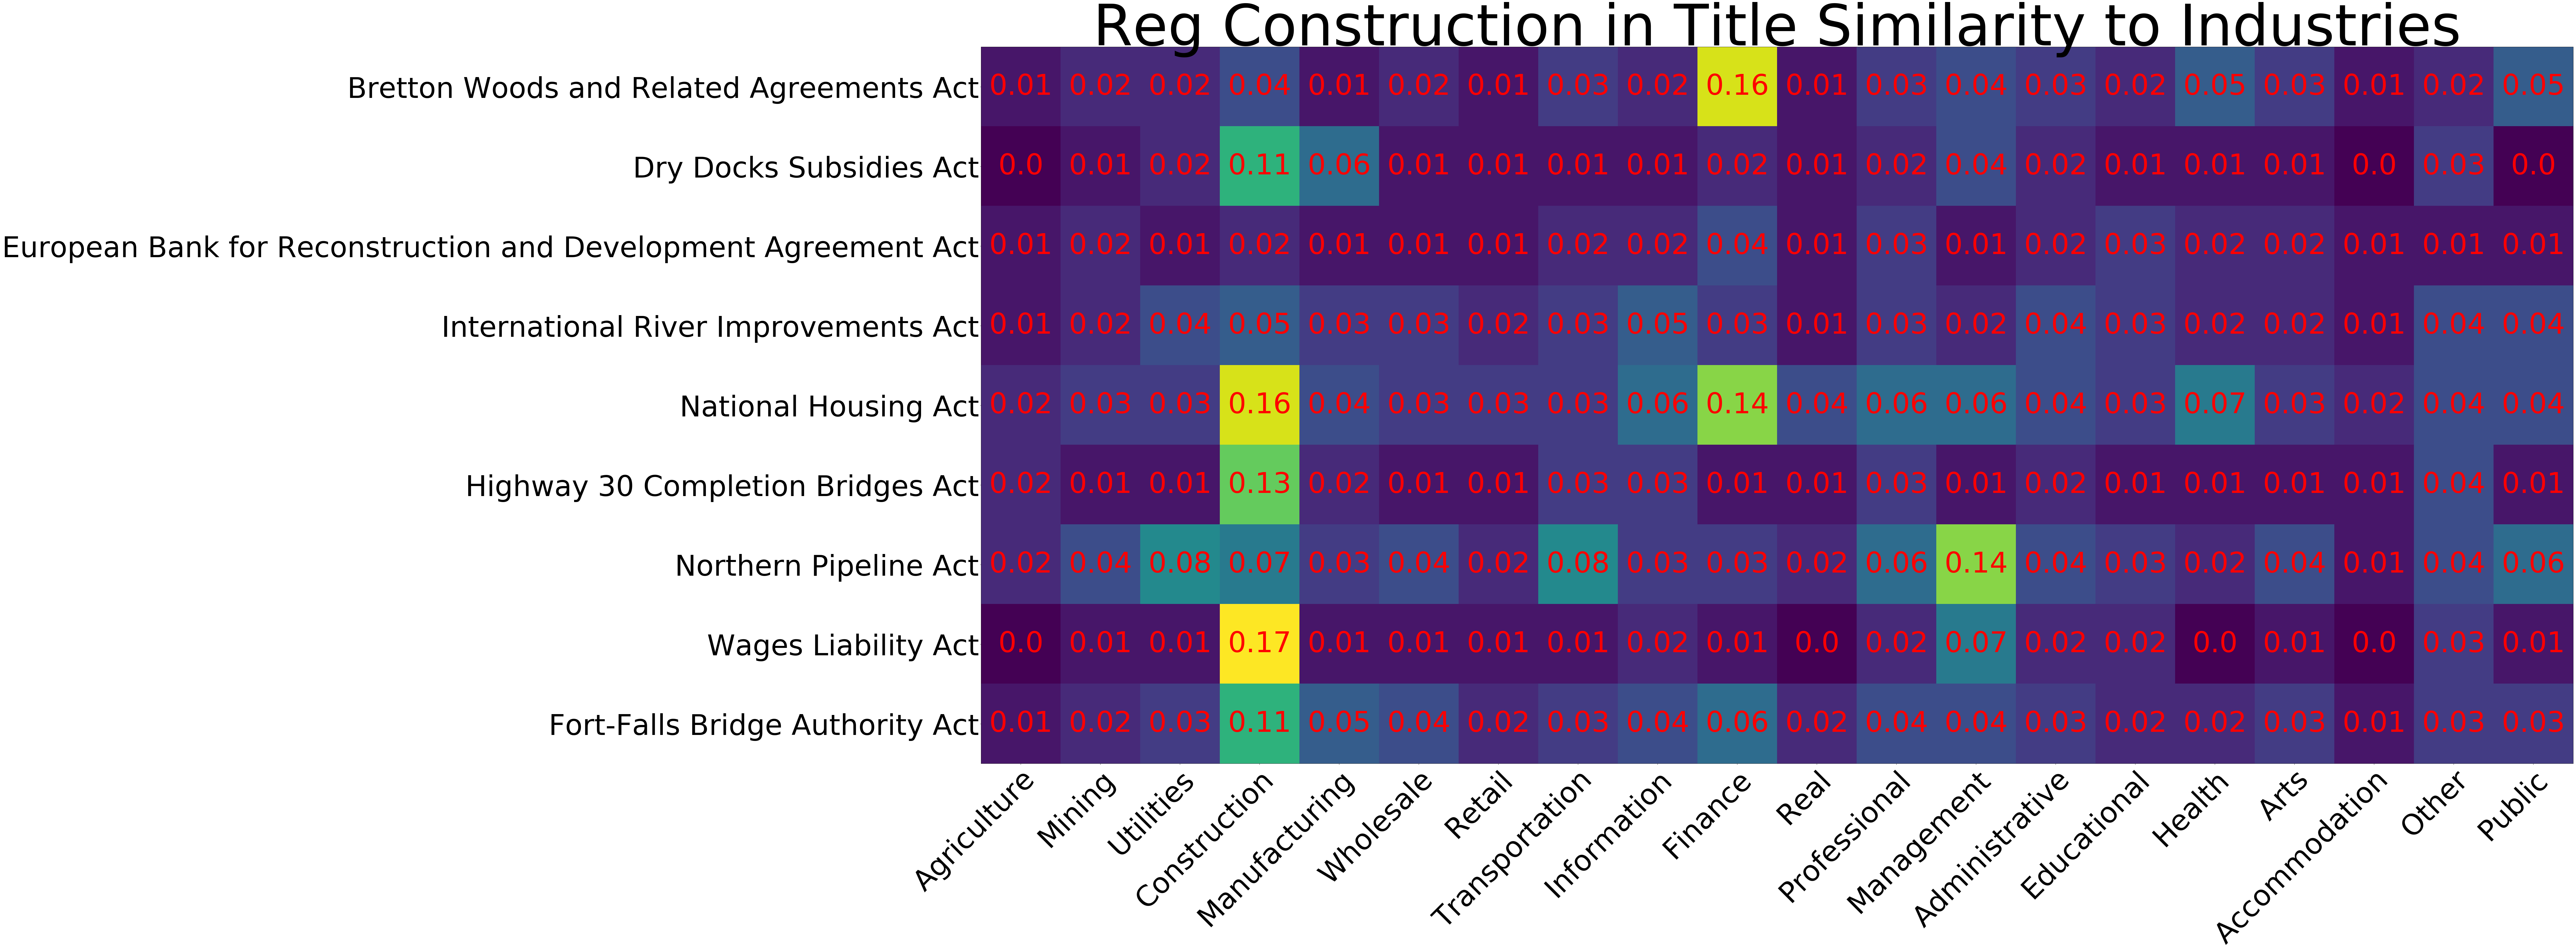

In [75]:
# Let's visualize the above
regulations = df['ShortTitle'][nn]
industries = [w.split()[0].replace(',', '') for w in list(industry['Class title'])]
data = similarity_matrix_orig[nn].round(2)
fig, ax = plt.subplots(figsize=(100,50))
im = ax.imshow(data, aspect='equal')
ax.set_xticks(np.arange(len(industries)))
ax.set_yticks(np.arange(len(regulations)))
ax.set_xticklabels(industries)
ax.set_yticklabels(regulations)
ax.tick_params(labelsize=100)
ax.set_title("Reg Construction in Title Similarity to Industries", size=200)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(len(regulations)):
    for j in range(len(industries)):
        text = ax.text(j, i, data[i, j],
                       ha="center", va="center", color="r", size=100)
plt.show()

## USE OF ARCHAIC LANGUAGE

In [76]:
outdated_tech = ['paper',
                 'scan',
                 'print',
                 'mail',
                 'fax',
                 'signature',
                 'written',
                 'pen',
                 'pencil',
                 'ink',
                 'physical',
                 'carbon copy',
                 'hard copy',
                 'original copy',
                 'in person',
                 'proof',
                 'signed',
                 'notary',
                 'on site',
                 'file',
                 'filing',
                 'submit']

In [77]:
stemmer = SnowballStemmer("english")
outdated_tech_stem = [stemmer.stem(w) for w in outdated_tech]

In [78]:
outdated_tech_string = ' | '.join(outdated_tech_stem)

In [79]:
def find_outdated_tech_terms(text):
    '''
    '''
    outdated_tech_count = len(re.findall(outdated_tech_string, text))
    return outdated_tech_count

In [80]:
df['OutdatedTechScore'] = df['BodyTextStems'].apply(find_outdated_tech_terms)

In [81]:
df.head()

,BillHistory,BillHistoryFormat,BodyText,LongTitle,Name,RunningHead,ShortTitle,XML,_id,Title,BodyTextStems,TitleStems,BodyTitleStems,OutdatedTechScore
0,"[1991, February, 1, 2018, 06, 21]","[YYYY, MM, DD, YYYY, MM, DD]",Short Title Short title 1 This Act may be cite...,An Act respecting a Day of Mourning for Person...,W-11.5.xml,Workers Mourning Day,Workers Mourning Day Act,"﻿<?xml version=""1.0"" encoding=""utf-8""?><!DOCTY...",5b671a827c33b10de5efedb4,An Act respecting a Day of Mourning for Person...,short titl short titl 1 act may cite worker mo...,act respect day mourn person kill injur workpl...,short titl short titl 1 act may cite worker mo...,0
1,"[2018, 06, 21, 2005, 11, 3]","[YYYY, MM, DD, YYYY, MM, DD]",Short Title Short title 1 This Act may be cite...,An Act to establish the Canada Border Services...,C-1.4.xml,Canada Border Services Agency,Canada Border Services Agency Act,"﻿<?xml version=""1.0"" encoding=""utf-8""?><!--Arb...",5b671a827c33b10de5efedb5,An Act to establish the Canada Border Services...,short titl short titl 1 act may cite canada bo...,act establish canada border servic agencycanad...,short titl short titl 1 act may cite canada bo...,0
2,"[2018, 06, 21, 2005, 3, 23]","[YYYY, MM, DD, YYYY, MM, DD]",Short Title Short title 1 This Act may be cite...,An Act to establish the Department of Public S...,P-31.55.xml,Department of Public Safety and Emergency Prep...,Department of Public Safety and Emergency Prep...,"﻿<?xml version=""1.0"" encoding=""utf-8""?><!--Arb...",5b671a827c33b10de5efedb6,An Act to establish the Department of Public S...,short titl short titl 1 act may cite depart pu...,act establish depart public safeti emerg prepa...,short titl short titl 1 act may cite depart pu...,0
3,"[2018, 06, 21]","[YYYY, MM, DD]",Short Title Short title 1 This Act may be cite...,An Act respecting Construction of Works for th...,I-19.8.xml,International Rapids,International Rapids Power Development Act,"﻿<?xml version=""1.0"" encoding=""utf-8""?><!--Arb...",5b671a827c33b10de5efedb7,An Act respecting Construction of Works for th...,short titl short titl 1 act may cite intern ra...,act respect construct work generat electr powe...,short titl short titl 1 act may cite intern ra...,0
4,"[2002, April, 1, 2018, 06, 21]","[YYYY, MM, DD, YYYY, MM, DD]",Short Title Short title 1 This Act may be cite...,An Act to establish the Canadian Air Transport...,C-11.2.xml,Canadian Air Transport Security Authority,Canadian Air Transport Security Authority Act,"﻿<?xml version=""1.0"" encoding=""utf-8""?><!--Arb...",5b671a827c33b10de5efedb8,An Act to establish the Canadian Air Transport...,short titl short titl 1 act may cite canadian ...,act establish canadian air transport secur aut...,short titl short titl 1 act may cite canadian ...,4


In [82]:
df['OutdatedTechScore'].describe()

count     851.000000
mean       16.461810
std        70.678423
min         0.000000
25%         0.000000
50%         1.000000
75%         8.000000
max      1285.000000
Name: OutdatedTechScore, dtype: float64

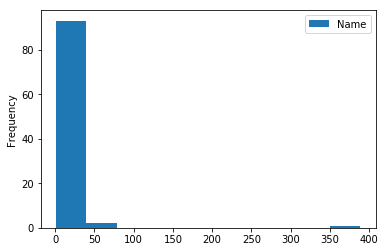

In [83]:
df[['Name','OutdatedTechScore']].groupby('OutdatedTechScore').count().plot(kind='hist')

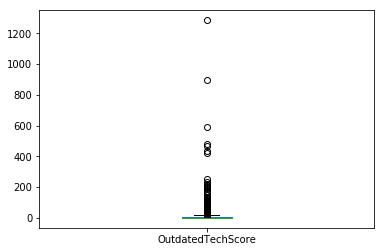

In [84]:
df[['OutdatedTechScore']].plot(kind='box')

In [85]:
len(df[df['OutdatedTechScore'] > 0])

462

In [86]:
df['BillHistoryLength'] = df['BillHistory'].apply(lambda x: len(x))

In [89]:
df['BillHistoryLength'].describe()

count    851.000000
mean       4.907168
std        1.444530
min        3.000000
25%        3.000000
50%        6.000000
75%        6.000000
max        6.000000
Name: BillHistoryLength, dtype: float64

In [144]:
def get_last_date(row):
    '''Gets the date earliest in time and converts it to a true date'''
    if row['BillHistoryLength'] == 6:
        date_format1 = '-'.join(row['BillHistoryFormat'][:3]).replace('YYYY', '%Y').replace('DD', '%d')
        date_format2 = '-'.join(row['BillHistoryFormat'][3:]).replace('YYYY', '%Y').replace('DD', '%d')
        if row['BillHistory'][1].lower() in ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']:
            date_format1 = date_format1.replace('MM', '%B')
        else:
            date_format1 = date_format1.replace('MM', '%m')
        if row['BillHistory'][4].lower() in ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']:
            date_format2 = date_format2.replace('MM', '%B')
        else:
            date_format2 = date_format2.replace('MM', '%m')         
        date1 = datetime.strptime('-'.join(row['BillHistory'][:3]), date_format1)
        date2 = datetime.strptime('-'.join(row['BillHistory'][3:]), date_format2)
        return min(date1, date2)
    else:
        date_format1 = '-'.join(row['BillHistoryFormat'][:3]).replace('YYYY', '%Y').replace('DD', '%d')
        if row['BillHistory'][1].lower() in ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']:
            date_format1 = date_format1.replace('MM', '%B')
        else:
            date_format1 = date_format1.replace('MM', '%m')
        date1 = datetime.strptime('-'.join(row['BillHistory'][:3]), date_format1)
        return date1


In [145]:
df['BillHistoryFirstDate'] = df.apply(get_last_date, axis=1)

In [149]:
df[['BillHistory', 'BillHistoryFormat', 'BillHistoryFirstDate']].head()

,BillHistory,BillHistoryFormat,BillHistoryFirstDate
0,"[1991, February, 1, 2018, 06, 21]","[YYYY, MM, DD, YYYY, MM, DD]",1991-02-01 00:00:00
1,"[2018, 06, 21, 2005, 11, 3]","[YYYY, MM, DD, YYYY, MM, DD]",2005-11-03 00:00:00
2,"[2018, 06, 21, 2005, 3, 23]","[YYYY, MM, DD, YYYY, MM, DD]",2005-03-23 00:00:00
3,"[2018, 06, 21]","[YYYY, MM, DD]",2018-06-21 00:00:00
4,"[2002, April, 1, 2018, 06, 21]","[YYYY, MM, DD, YYYY, MM, DD]",2002-04-01 00:00:00


In [200]:
min_date = min(list(df[df['OutdatedTechScore'] > 0]['BillHistoryFirstDate']))
max_date = max(list(df[df['OutdatedTechScore'] > 0]['BillHistoryFirstDate']))
print min_date, max_date

1871-04-14 00:00:00 2018-06-21 00:00:00


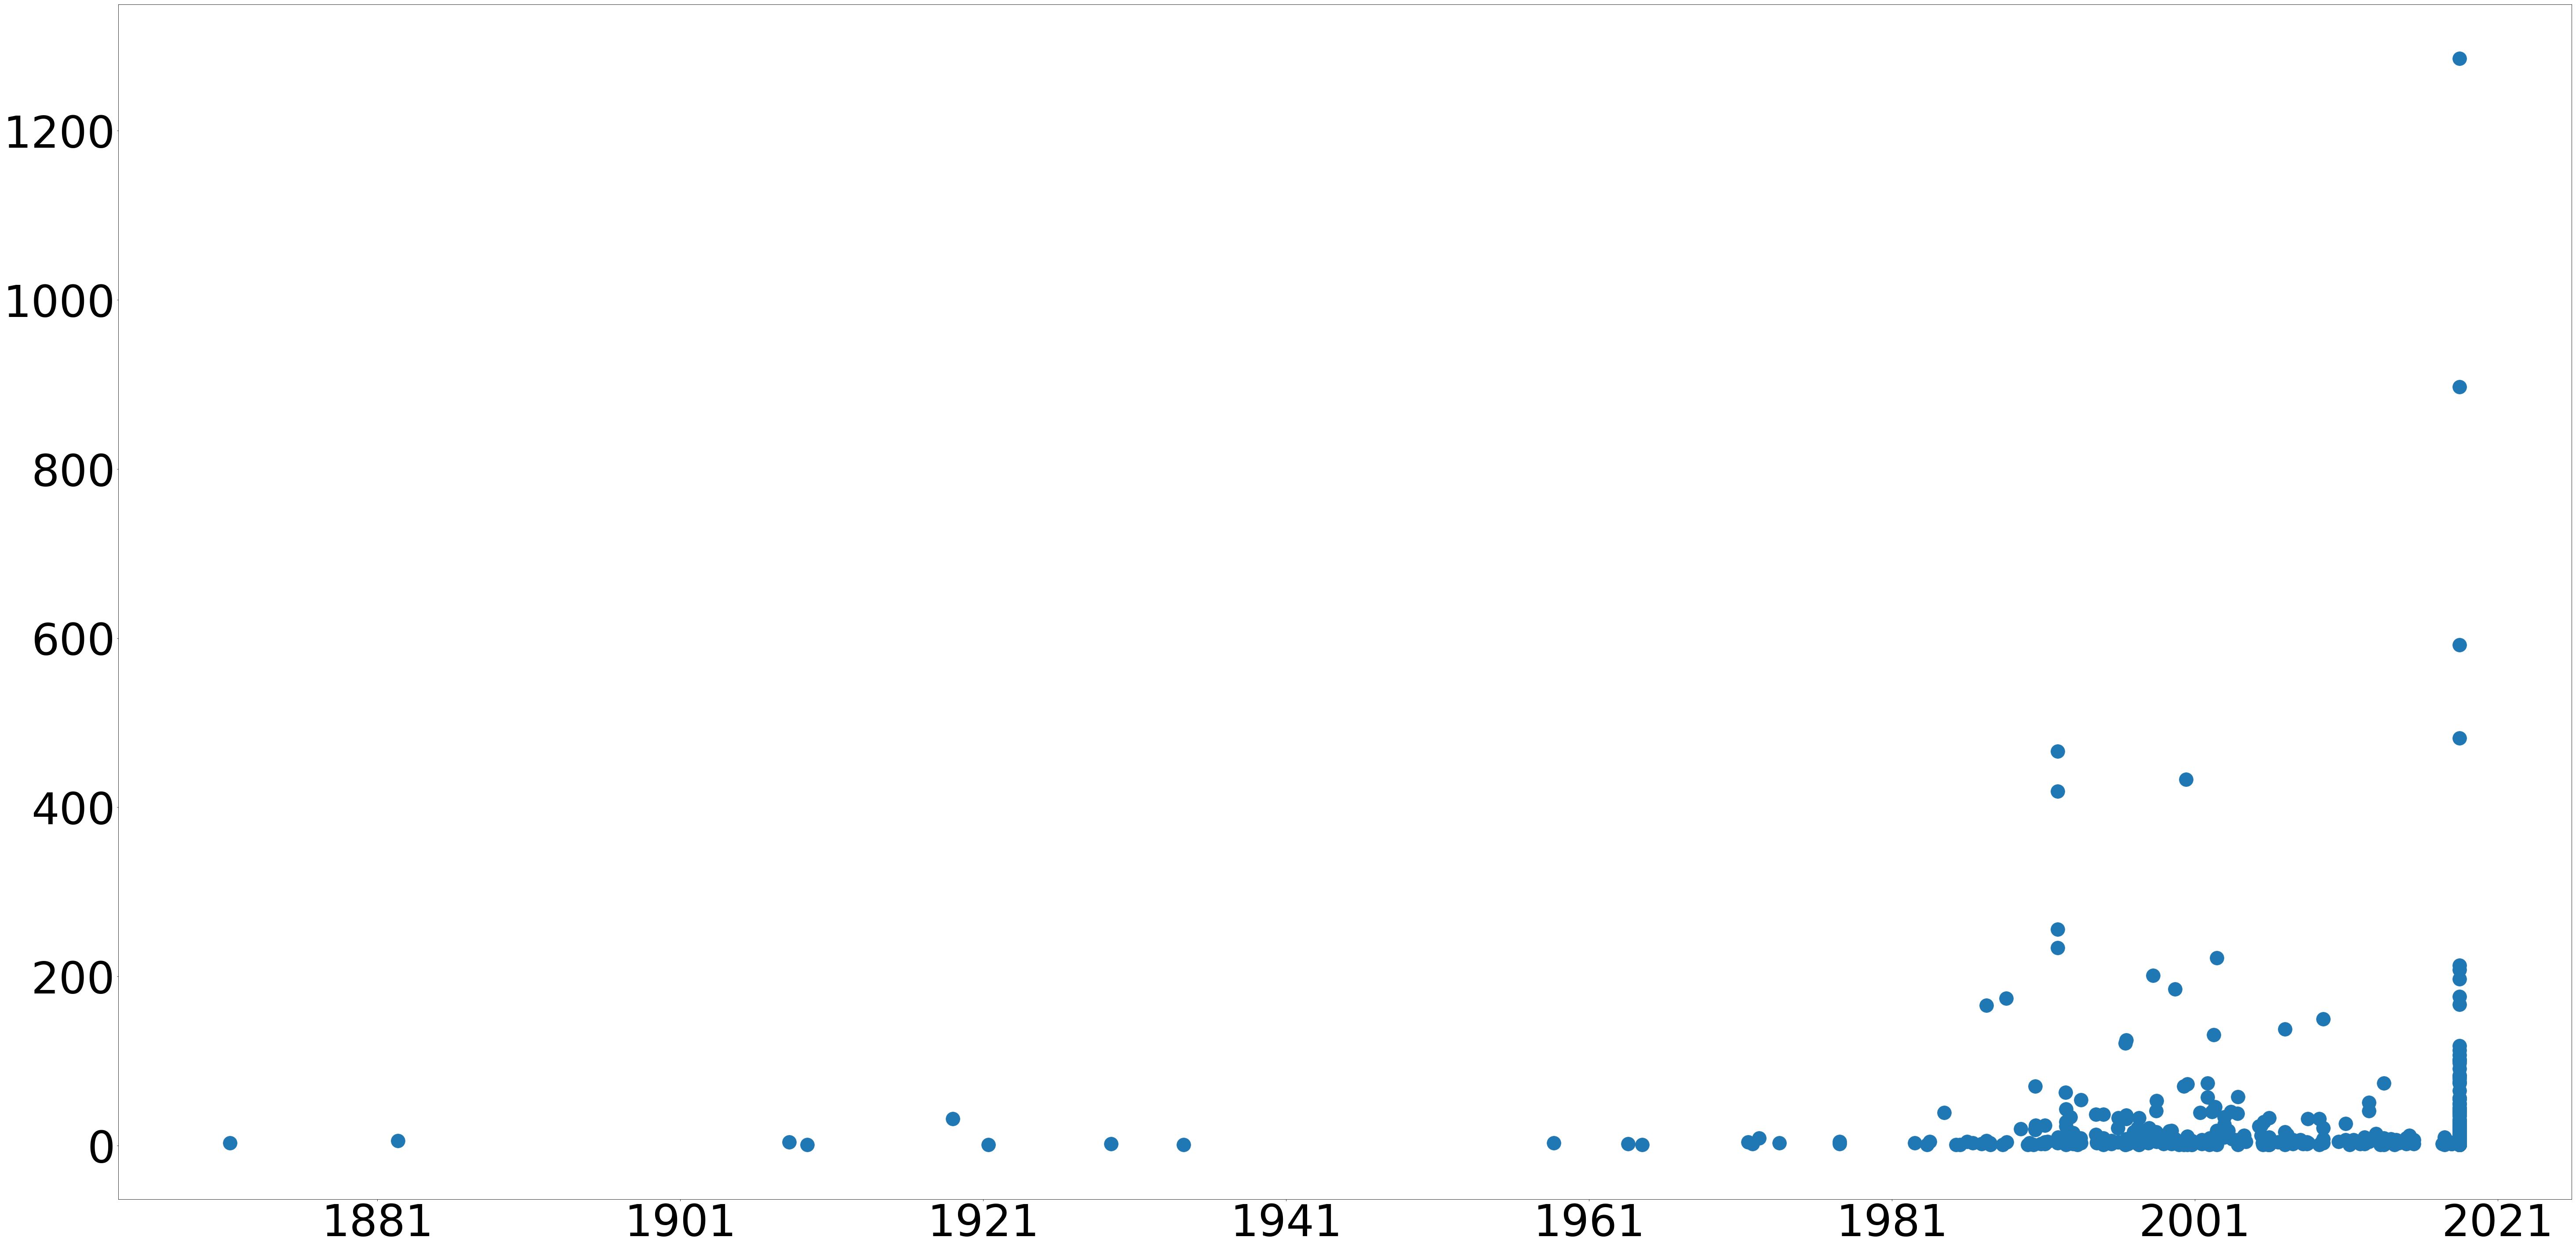

In [225]:
X = list(df[df['OutdatedTechScore'] > 0]['BillHistoryFirstDate'])
Y = list(df[df['OutdatedTechScore'] > 0]['OutdatedTechScore'])
S = list(df[df['OutdatedTechScore'] > 0]['OutdatedTechScore'])
fig, ax = plt.subplots(figsize=(100,50))
plt.scatter(X, Y, s=1000)
ax.tick_params(labelsize=100)
plt.show()

## APPENDIX - Using deeplearning to translate dates

The below appendix implements a Neural Machine Translation (NMT) model to translate human readable dates ("25th of June, 2009") into machine readable dates ("2009-06-25"). We will do this using an attention model, one of the most sophisticated sequence to sequence models.

In [2]:
from keras.models import load_model, Model
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
import keras.backend as K
from keras.utils import to_categorical
import numpy as np

Using TensorFlow backend.


In [3]:
def string_to_int(string, length, vocab):
    """
    Converts all strings in the vocabulary into a list of integers representing the positions of the
    input string's characters in the "vocab"
    
    Arguments:
    string -- input string, e.g. 'Wed 10 Jul 2007'
    length -- the number of time steps you'd like, determines if the output will be padded or cut
    vocab -- vocabulary, dictionary used to index every character of your "string"
    
    Returns:
    rep -- list of integers (or '<unk>') (size = length) representing the position of the string's character in the vocabulary
    """
    
    #make lower to standardize
    string = string.lower()
    string = string.replace(',','')
    
    if len(string) > length:
        string = string[:length]
        
    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))
    
    if len(string) < length:
        rep += [vocab['<pad>']] * (length - len(string))
    
    #print (rep)
    return rep


In [4]:
def softmax(x, axis=1):
    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

In [5]:
def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator([a, s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas, a])
    
    return context

In [6]:
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    # Step 1: Define your pre-attention Bi-LSTM. Remember to use return_sequences=True. (≈ 1 line)
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(inputs=context, initial_state=[s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(input=[X, s0, c0], output=outputs )
    
    return model

We will also use Tx=30 (which we assume is the maximum length of the human readable date; if we get a longer input, we would have to truncate it) and Ty=10 (since "YYYY-MM-DD" is 10 characters long)

In [7]:
Tx = 30
Ty = 10

We are loading:
- `human_vocab`: a python dictionary mapping all characters used in the human readable dates to an integer-valued index 
- `inv_machine_vocab`: a python dictionary mapping from an integer-valued index all characters used in machine readable dates. 

In [8]:
p = '/Users/be08178/Documents/B&P/CanadianGovernment/RNNDateTranslation/'
f = open(p+'human_vocab.txt','r') 
human_vocab = eval(f.read())
f = open(p+'inv_machine_vocab.txt','r') 
inv_machine_vocab = eval(f.read())

In [9]:
# Defining shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [10]:
# Defining global layers that will share weights to be used in model()
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(11, activation=softmax)

In [11]:
# Creating the model architecture
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(inv_machine_vocab))
opt = Adam(lr=0.005,  beta_1=0.9, beta_2=0.999 , decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

/Users/be08178/anaconda3/envs/nlp/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


In [12]:
# We have fitted the model on a training set, and saved the weights.
model.load_weights('/Users/be08178/Documents/B&P/CanadianGovernment/model/model_weights.h5')

In [13]:
# Defining all your inputs and outputs
m = 10000 # Number of training examples
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))

In [14]:
# Let's see the results on new examples.
EXAMPLES = ['3 May 1979', 'Apr 4 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, 30, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

('source:', '3 May 1979')
('output:', '1979-05-03')
('source:', 'Apr 4 09')
('output:', '2009-04-04')
('source:', '21th of August 2016')
('output:', '2016-08-21')
('source:', 'Tue 10 Jul 2007')
('output:', '2007-07-10')
('source:', 'Saturday May 9 2018')
('output:', '2018-05-09')
('source:', 'March 3 2001')
('output:', '2001-03-03')
('source:', 'March 3rd 2001')
('output:', '2001-03-03')
('source:', '1 March 2001')
('output:', '2001-03-01')


As you can see the model is able to successfully translate most dates written in a variety of ways, but it's not perfect (yet).  Of course the model can keep learning and improve to eventually get very close to human level of accuracy.